## Data Analysis

(1, 128, 128)


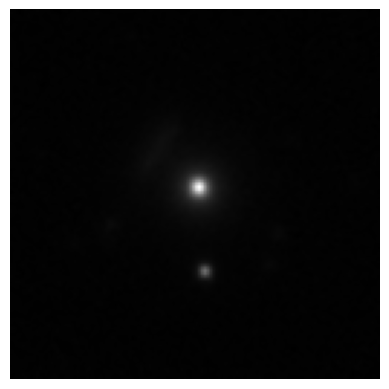

In [33]:
import numpy as np
import matplotlib.pyplot as plt

## HR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-3b/Dataset/HR/HR_127.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  


# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

(1, 64, 64)


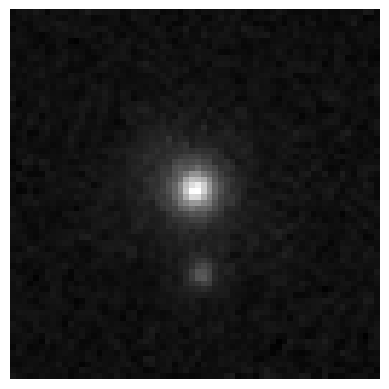

In [34]:
import numpy as np
import matplotlib.pyplot as plt

## LR

# Load the image
img = np.load("/kaggle/input/gsoc-dataset-3b/Dataset/LR/LR_127.npy")
print(img.shape)
# Convert from (C, H, W) to (H, W, C)
img = np.transpose(img, (1, 2, 0))  

# Display the image
plt.imshow(img, cmap="gray")  # Use cmap="gray" if it's a grayscale image
plt.axis("off")  # Hide axes
plt.show()

## Configurations

In [35]:
import torch

class CFG:
    def __init__(self):
        self.lr_folder = "/kaggle/input/gsoc-dataset-3b/Dataset/LR"
        self.hr_folder = "/kaggle/input/gsoc-dataset-3b/Dataset/HR"
        self.batch_size = 64
        self.val_batch_size = 16
        self.num_workers = 4
        self.train_size = 0.9
        
        self.model_d = 56
        self.model_s = 12
        self.model_m = 4

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lr_init = 0.0001
        self.epochs = 40
        self.L1_loss_weightage = 0.5
        self.perceptual_loss_model = "densenet169"
        self.perceptual_loss_model_wts = "/kaggle/input/densenet169-best/pytorch/default/1/densenet169_best.pth"
        self.base_model = "/kaggle/input/fsrcnn-base-model/pytorch/default/1/best_fsrcnn_model_best.pth"
        self.weights_fn = "best_modified_fsrcnn_model.pth"

config = CFG()

## Data Preparation

In [36]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import yaml
import argparse
import random
import torchvision.transforms as transforms

class CustomNPYDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, set_type, train_size):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        # self.augment = augment
        self.hr_image_fns = sorted([f for f in os.listdir(hr_folder) if f.endswith(".npy")],
                                key=lambda x: int((x.split(".")[0]).split("_")[1]))
        self.lr_image_fns = sorted([f for f in os.listdir(lr_folder) if f.endswith(".npy")],
                                key=lambda x: int((x.split(".")[0]).split("_")[1]))
        
        # Split the dataset based on set_type (train, val)
        if set_type == "train":
            self.hr_image_fns = self.hr_image_fns[:int(len(self.hr_image_fns) * train_size)]
            self.lr_image_fns = self.lr_image_fns[:int(len(self.lr_image_fns) * train_size)]
        else:  # for validation
            self.hr_image_fns = self.hr_image_fns[int(len(self.hr_image_fns) * train_size):]
            self.lr_image_fns = self.lr_image_fns[int(len(self.lr_image_fns) * train_size):]

        # # Define augmentation transforms
        # self.transform = transforms.Compose([
        #     transforms.RandomHorizontalFlip(p=0.5),
        #     transforms.RandomVerticalFlip(p=0.5),
        #     transforms.RandomRotation(degrees=(0, 270)),
        #     transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x) if random.random() < 0.3 else x),
        # ])

    def __len__(self):
        return len(self.hr_image_fns)

    def __getitem__(self, idx):
        hr_image_fn = self.hr_image_fns[idx]
        lr_image_fn = self.lr_image_fns[idx]
        lr_image = np.load(os.path.join(self.lr_folder, lr_image_fn))
        hr_image = np.load(os.path.join(self.hr_folder, hr_image_fn))

        # Normalize to float32 and convert to tensors
        lr_image = torch.tensor(lr_image, dtype=torch.float32) / 255.0
        hr_image = torch.tensor(hr_image, dtype=torch.float32) / 255.0

        # # Apply augmentations if enabled
        # if self.augment:
        #     lr_image = self.transform(lr_image)
        #     hr_image = self.transform(hr_image)
        
        return lr_image, hr_image


## Model

In [37]:
class FSRCNN(nn.Module):
    def __init__(self, d, s, m):
        super(FSRCNN, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )
        self.mapping = nn.Sequential(*[nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=1), nn.PReLU()) for _ in range(m)])
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        self.deconv = nn.ConvTranspose2d(d, 1, kernel_size=9, stride=2, padding=4, output_padding=1)
    
    def forward(self, x):
        x = self.feature_extraction(x) # input channel is 1
        x = self.shrinking(x)
        x = self.mapping(x)
        x = self.expanding(x)
        x = self.deconv(x)
        return x

### Testing Model

In [38]:
# Test with a low-resolution image
lr_images = torch.randn(1, 1, 64, 64)  # Simulating a batch of 1 LR image
testing_model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m)
testing_model.load_state_dict(torch.load("/kaggle/input/fsrcnn-base-model/pytorch/default/1/best_fsrcnn_model_best.pth", weights_only=True))
testing_outputs = testing_model(lr_images)
print("LR Image Shape:", lr_images.shape)    # (1, 1, 75, 75)
print("Model Output Shape:", testing_outputs.shape)  # (1, 1, 128, 128) ✅

LR Image Shape: torch.Size([1, 1, 64, 64])
Model Output Shape: torch.Size([1, 1, 128, 128])


## Loss function

In [39]:
import timm
import torch
import torch.nn as nn
import torchvision.models as models
# Perceptual model class
class DenseNetModel(nn.Module):
    def __init__(self, model_name=config.perceptual_loss_model, pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = timm.create_model(self.model_name, pretrained=self.pretrained, in_chans=1)
        clsf = self.model.default_cfg['classifier']
        self.model._modules[clsf] = nn.Identity()
        
    def forward(self, x):
        x = self.model(x)
        return x

class CustomLoss(nn.Module):
    def __init__(self, perceptual_model_path, device=config.device):
        super(CustomLoss, self).__init__()
        self.densenet = DenseNetModel()
        checkpoint = torch.load(perceptual_model_path)
        self.densenet.load_state_dict(checkpoint["model"], strict=False)
        self.densenet.to(device)
        
        # Freeze DenseNet weights
        for param in self.densenet.parameters():
            param.requires_grad = False
        self.densenet.eval()
        
        # L1 loss for pixel-wise comparison
        self.l1 = nn.L1Loss()

    def forward(self, pred, target, alpha=config.L1_loss_weightage):
        densenet_pred = self.densenet(pred)
        densenet_target = self.densenet(target)
        
        perceptual_loss = self.l1(densenet_pred, densenet_target)
        pixel_loss = self.l1(pred, target)
        
        return perceptual_loss, pixel_loss, ((perceptual_loss / 2) * (1 - alpha)) + (pixel_loss * alpha)

### Testing Loss function

In [40]:
hr_images = torch.randn(1, 1, 128, 128).to(config.device)  # Simulating a batch of 1 HR image
testing_criterion = CustomLoss(config.perceptual_loss_model_wts)
perceptual_loss, pixel_loss, testing_loss = testing_criterion(testing_outputs.to(config.device), hr_images)
print("perceptual loss: ", perceptual_loss.item(), " and pixel loss: ", pixel_loss.item())
print(testing_loss.item())

perceptual loss:  5.139622211456299  and pixel loss:  6.932541847229004
4.751176357269287


## Training

In [41]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def visualize_predictions(config, model, dataset, device, num_images=10):
    """Displays predicted vs actual HR images for a given dataset."""
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one image at a time for visualization
        shuffle=True,  # Randomly pick images
        num_workers=config.num_workers
    )

    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
    axes[0, 0].set_title("LR Image")
    axes[0, 1].set_title("Predicted HR Image")
    axes[0, 2].set_title("Actual HR Image")

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            if i >= num_images:  
                break  # Stop after visualizing `num_images`

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy
            lr_np = lr_images.cpu().squeeze().numpy()
            pred_hr_np = outputs.cpu().squeeze().numpy()
            hr_np = hr_images.cpu().squeeze().numpy()

            # Plot images
            axes[i, 0].imshow(lr_np, cmap="gray")  # LR Image
            axes[i, 1].imshow(pred_hr_np, cmap="gray")  # Predicted HR Image
            axes[i, 2].imshow(hr_np, cmap="gray")  # Ground Truth HR Image

            for j in range(3):
                axes[i, j].axis("off")  # Remove axes

    plt.tight_layout()
    plt.show()

def train(config, train_loss_list, val_loss_list):
    # Dataset and DataLoader
    train_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="train",
        train_size=config.train_size
    )
    val_dataset = CustomNPYDataset(
        lr_folder=config.lr_folder,
        hr_folder=config.hr_folder,
        set_type="val",
        train_size=config.train_size
    )

    print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
    print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.val_batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    # Model
    model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m)
    model.load_state_dict(torch.load(config.base_model, weights_only=True))
    device = config.device
    model = model.to(device)

    # Loss and Optimizer
    # criterion = CustomLoss(config.perceptual_loss_model_wts)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr_init)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=20, min_lr=1e-6, verbose=True
    )

    # Training Loop
    best_val_loss = float("inf")
    for epoch in range(config.epochs):
        print(f"Epoch {epoch + 1}/{config.epochs}")
        model.train()
        train_loss = 0.0
        train_perceptual_loss = 0.0
        train_pixel_loss = 0.0

        for lr_images, hr_images in tqdm(train_loader, desc="Training"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Forward pass
            outputs = model(lr_images)
            # perceptual_loss, pixel_loss, loss = criterion(outputs, hr_images)
            loss = criterion(outputs, hr_images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            # train_perceptual_loss += perceptual_loss.item()
            # train_pixel_loss += pixel_loss.item()

        train_loss /= len(train_loader)
        # train_perceptual_loss /= len(train_loader)
        # train_pixel_loss /= len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for lr_images, hr_images in tqdm(val_loader, desc="Validation"):
                lr_images, hr_images = lr_images.to(device), hr_images.to(device)

                # Forward pass
                outputs = model(lr_images)
                loss = criterion(outputs, hr_images)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        # print("train perceptual loss: ", train_perceptual_loss, " and train pixel loss: ", train_pixel_loss)
        print(f"Training Loss: {train_loss:.6f} and", f"Validation Loss: {val_loss:.6f}")

        # Checkpoint and Learning Rate Scheduler
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config.weights_fn)
            print(f"Saved Best Model to {config.weights_fn}")

        if (epoch+1) % 10 == 0:
            print("Img of Validation:")
            visualize_predictions(config, model, val_dataset, device, num_images=2)
            print("Img of Training:")
            visualize_predictions(config, model, train_dataset, device, num_images=2)
            

        print("-" * 50)

Train Size:  90.0 %
Validation Size:  10.0 %
Epoch 1/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


Training Loss: 0.000195 and Validation Loss: 0.000181
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 2/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.85it/s]


Training Loss: 0.000125 and Validation Loss: 0.000142
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 3/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.75it/s]


Training Loss: 0.000103 and Validation Loss: 0.000106
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 4/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


Training Loss: 0.000085 and Validation Loss: 0.000098
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 5/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]


Training Loss: 0.000082 and Validation Loss: 0.000089
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 6/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]


Training Loss: 0.000075 and Validation Loss: 0.000090
--------------------------------------------------
Epoch 7/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


Training Loss: 0.000076 and Validation Loss: 0.000089
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 8/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


Training Loss: 0.000076 and Validation Loss: 0.000088
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 9/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


Training Loss: 0.000075 and Validation Loss: 0.000086
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 10/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


Training Loss: 0.000073 and Validation Loss: 0.000085
Saved Best Model to best_modified_fsrcnn_model.pth
Img of Validation:


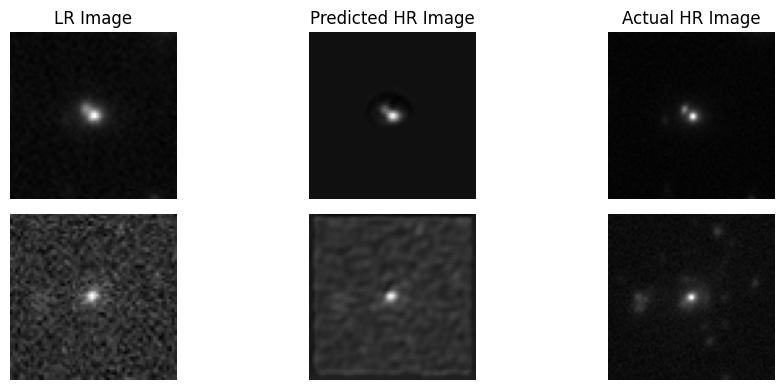

Img of Training:


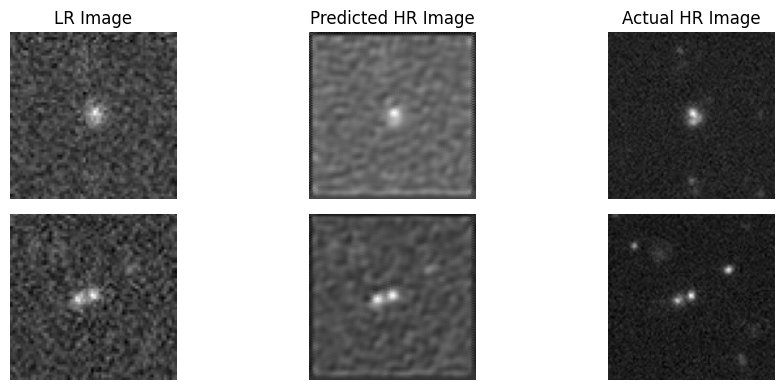

--------------------------------------------------
Epoch 11/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


Training Loss: 0.000072 and Validation Loss: 0.000085
--------------------------------------------------
Epoch 12/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]


Training Loss: 0.000074 and Validation Loss: 0.000085
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 13/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


Training Loss: 0.000076 and Validation Loss: 0.000087
--------------------------------------------------
Epoch 14/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]


Training Loss: 0.000076 and Validation Loss: 0.000084
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 15/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]


Training Loss: 0.000077 and Validation Loss: 0.000084
--------------------------------------------------
Epoch 16/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


Training Loss: 0.000074 and Validation Loss: 0.000085
--------------------------------------------------
Epoch 17/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]


Training Loss: 0.000074 and Validation Loss: 0.000086
--------------------------------------------------
Epoch 18/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.81it/s]


Training Loss: 0.000079 and Validation Loss: 0.000091
--------------------------------------------------
Epoch 19/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


Training Loss: 0.000077 and Validation Loss: 0.000086
--------------------------------------------------
Epoch 20/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


Training Loss: 0.000073 and Validation Loss: 0.000085
Img of Validation:


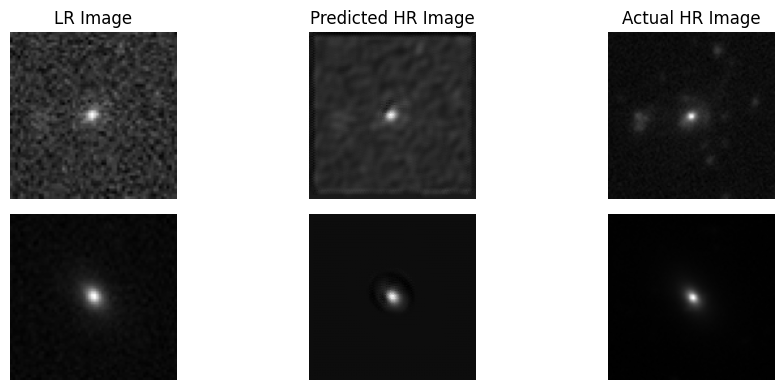

Img of Training:


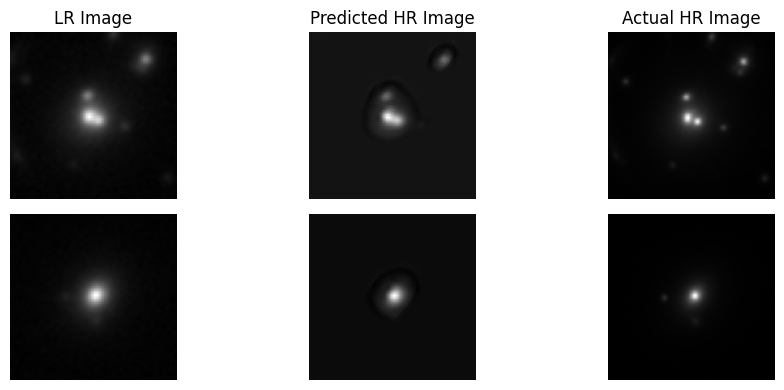

--------------------------------------------------
Epoch 21/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


Training Loss: 0.000075 and Validation Loss: 0.000082
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 22/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.62it/s]


Training Loss: 0.000074 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 23/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.15it/s]


Training Loss: 0.000075 and Validation Loss: 0.000092
--------------------------------------------------
Epoch 24/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


Training Loss: 0.000073 and Validation Loss: 0.000085
--------------------------------------------------
Epoch 25/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.07it/s]


Training Loss: 0.000082 and Validation Loss: 0.000091
--------------------------------------------------
Epoch 26/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.19it/s]


Training Loss: 0.000079 and Validation Loss: 0.000086
--------------------------------------------------
Epoch 27/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.57it/s]


Training Loss: 0.000079 and Validation Loss: 0.000086
--------------------------------------------------
Epoch 28/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


Training Loss: 0.000072 and Validation Loss: 0.000082
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 29/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


Training Loss: 0.000075 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 30/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


Training Loss: 0.000072 and Validation Loss: 0.000085
Img of Validation:


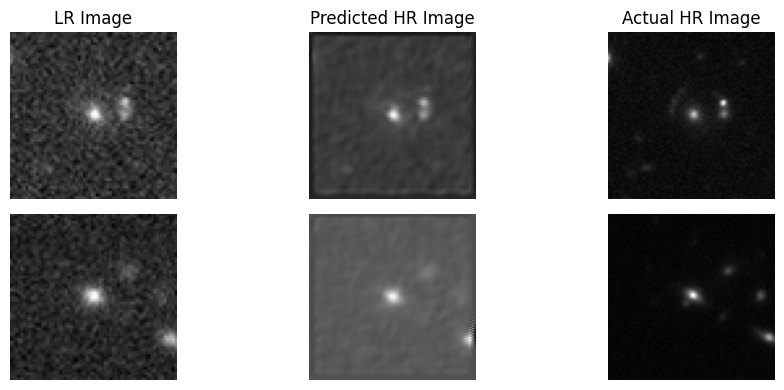

Img of Training:


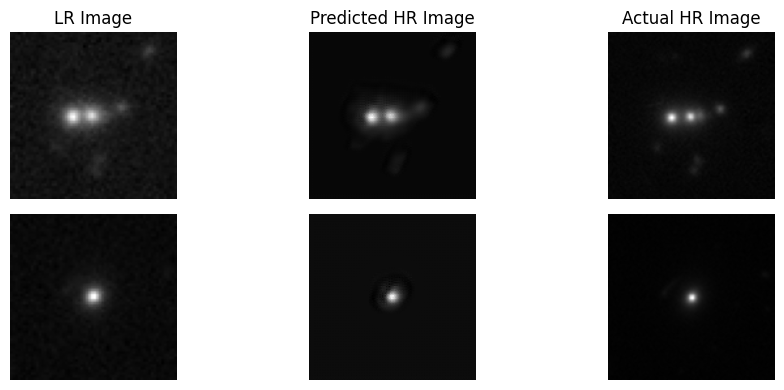

--------------------------------------------------
Epoch 31/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


Training Loss: 0.000072 and Validation Loss: 0.000082
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 32/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]


Training Loss: 0.000078 and Validation Loss: 0.000084
--------------------------------------------------
Epoch 33/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


Training Loss: 0.000075 and Validation Loss: 0.000082
Saved Best Model to best_modified_fsrcnn_model.pth
--------------------------------------------------
Epoch 34/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


Training Loss: 0.000075 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 35/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


Training Loss: 0.000074 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 36/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]


Training Loss: 0.000071 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 37/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]


Training Loss: 0.000081 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 38/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


Training Loss: 0.000080 and Validation Loss: 0.000084
--------------------------------------------------
Epoch 39/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


Training Loss: 0.000069 and Validation Loss: 0.000082
--------------------------------------------------
Epoch 40/40


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]


Training Loss: 0.000074 and Validation Loss: 0.000083
Img of Validation:


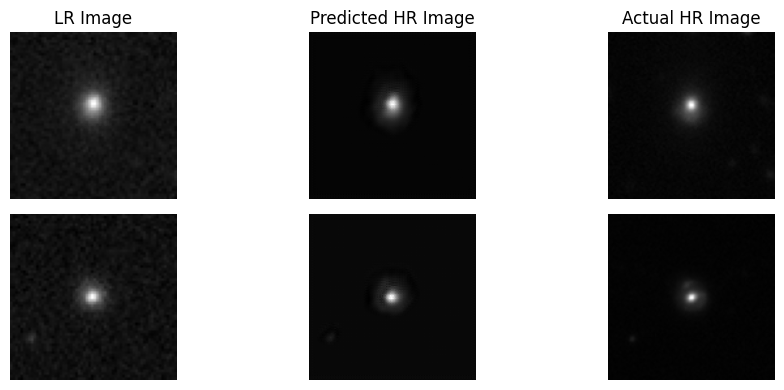

Img of Training:


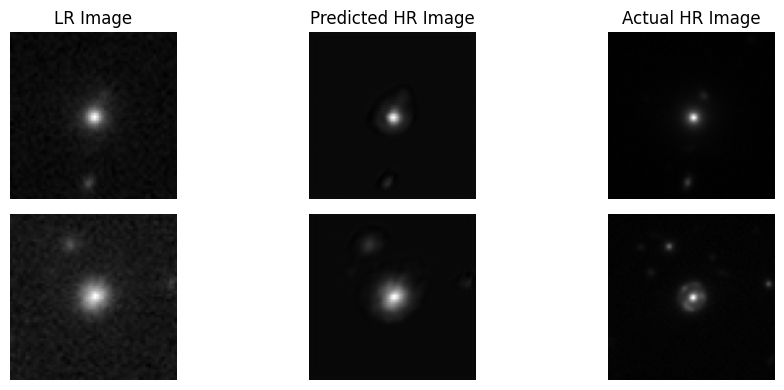

--------------------------------------------------


In [42]:
import warnings

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    train_loss_list = []
    val_loss_list = []
    train(config, train_loss_list, val_loss_list)

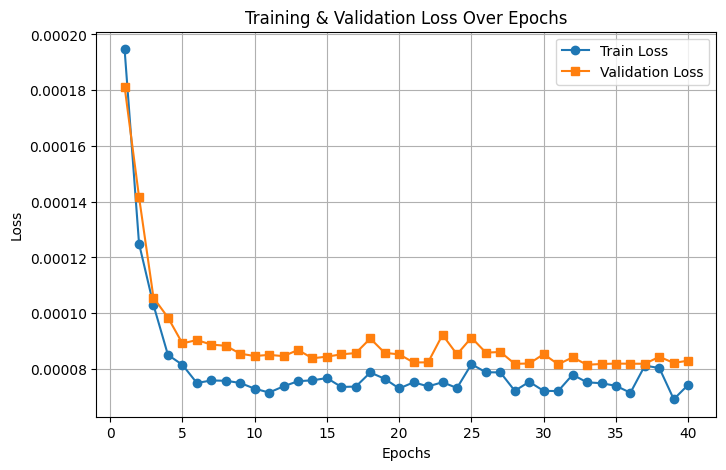

In [43]:
import matplotlib.pyplot as plt

def plot_loss(train_loss_list, val_loss_list):
    epochs = range(1, len(train_loss_list) + 1)  # X-axis: Epochs

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_list, label="Train Loss", marker="o", linestyle="-")
    plt.plot(epochs, val_loss_list, label="Validation Loss", marker="s", linestyle="-")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training
plot_loss(train_loss_list, val_loss_list)

## Evaluation Metrics

In [45]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_metrics(config, model, dataset, device, dataset_name="Train"):
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # SSIM, PSNR, and MSE are calculated per image
        shuffle=False,
        num_workers=config.num_workers
    )

    ssim_scores = []
    psnr_scores = []
    mse_scores = []  # Added MSE storage

    model.eval()
    with torch.no_grad():
        for lr_images, hr_images in tqdm(dataloader, desc=f"Evaluating {dataset_name} Dataset"):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy arrays
            hr_np = hr_images.cpu().squeeze().numpy()
            out_np = outputs.cpu().squeeze().numpy()

            # Compute SSIM and PSNR
            ssim_value = ssim(hr_np, out_np, data_range=out_np.max() - out_np.min())
            psnr_value = psnr(hr_np, out_np, data_range=out_np.max() - out_np.min())

            # Compute MSE
            mse_value = F.mse_loss(outputs, hr_images).item()  # Using PyTorch MSE

            ssim_scores.append(ssim_value)
            psnr_scores.append(psnr_value)
            mse_scores.append(mse_value)  # Store MSE

    # Compute average SSIM, PSNR, and MSE
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)  # Compute average MSE

    print(f"Average SSIM for {dataset_name} Dataset: {avg_ssim:.4f}")
    print(f"Average PSNR for {dataset_name} Dataset: {avg_psnr:.4f} dB")
    print(f"Average MSE for {dataset_name} Dataset: {avg_mse:.9f}")  # Print MSE with 9 decimals
    print("-" * 50)
    
    return avg_ssim, avg_psnr, avg_mse

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m).to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

train_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="train",
    train_size=config.train_size
)
val_dataset = CustomNPYDataset(
    lr_folder=config.lr_folder,
    hr_folder=config.hr_folder,
    set_type="val",
    train_size=config.train_size
)

print("Train Size: ", (len(train_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")
print("Validation Size: ", (len(val_dataset)/(len(train_dataset)+len(val_dataset)))*100,"%")

# Evaluate Train and Validation datasets (Now Includes MSE)
train_ssim, train_psnr, train_mse = evaluate_metrics(config, model, train_dataset, device, "Train")
val_ssim, val_psnr, val_mse = evaluate_metrics(config, model, val_dataset, device, "Validation")


Train Size:  90.0 %
Validation Size:  10.0 %


Evaluating Train Dataset: 100%|██████████| 270/270 [00:01<00:00, 201.83it/s]


Average SSIM for Train Dataset: 0.7202
Average PSNR for Train Dataset: 27.9210 dB
Average MSE for Train Dataset: 0.000000023
--------------------------------------------------


Evaluating Validation Dataset: 100%|██████████| 30/30 [00:00<00:00, 109.93it/s]

Average SSIM for Validation Dataset: 0.7179
Average PSNR for Validation Dataset: 27.7687 dB
Average MSE for Validation Dataset: 0.000000026
--------------------------------------------------


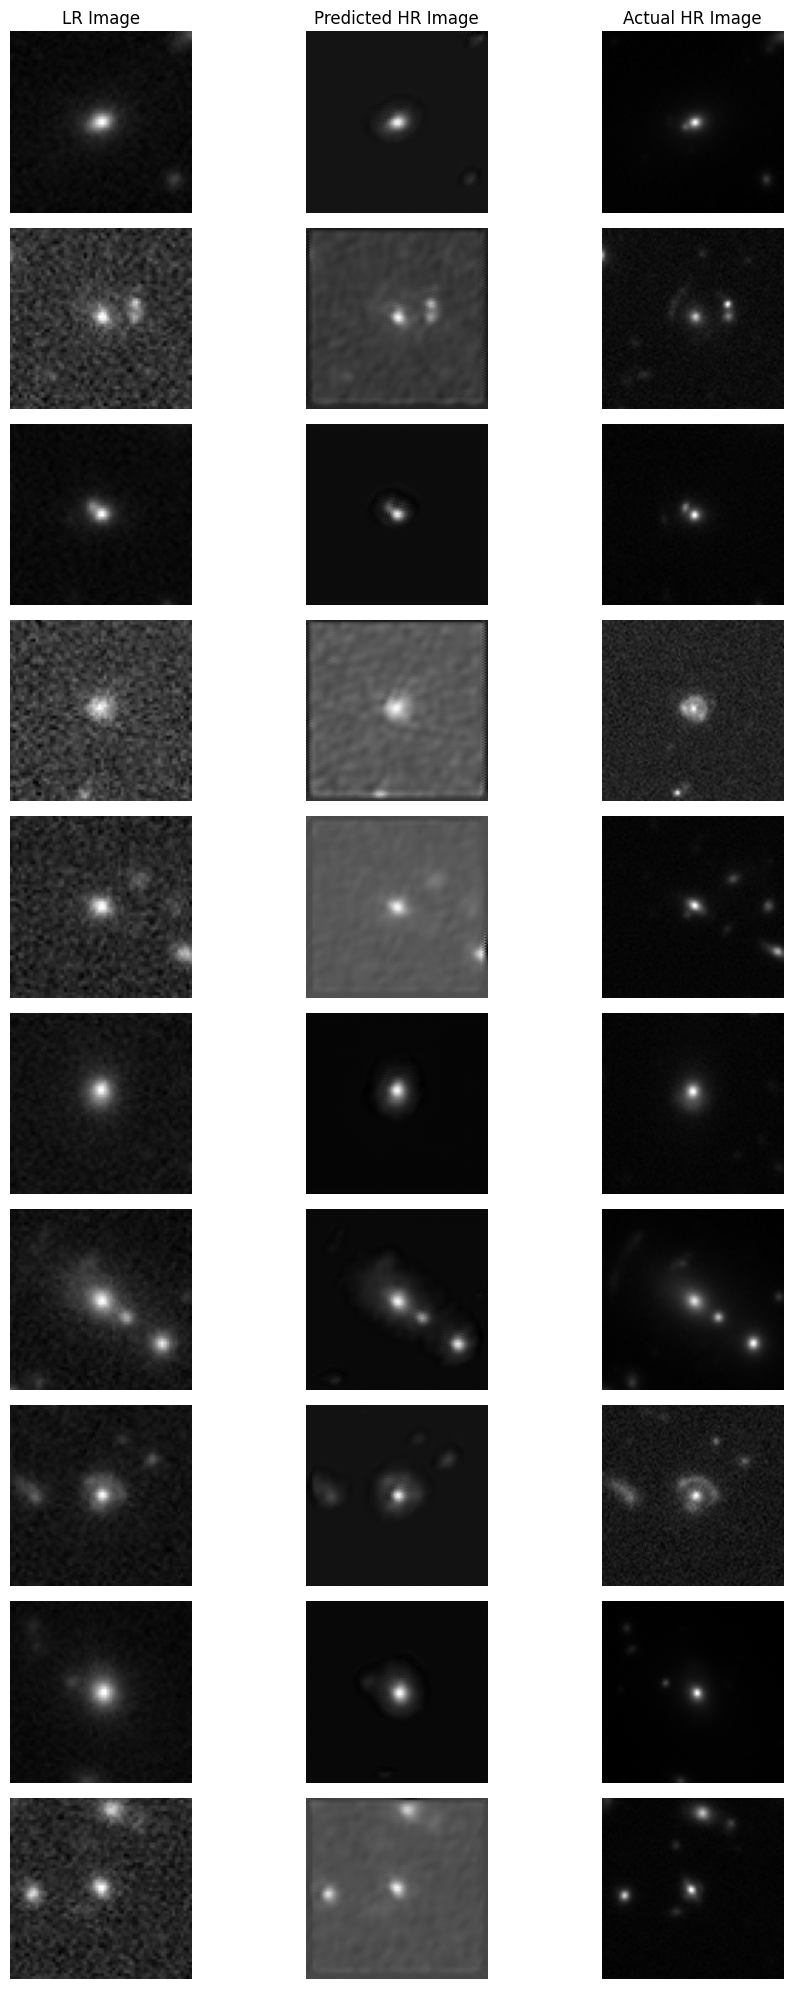

In [47]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def visualize_predictions(config, model, dataset, device, num_images=10):
    """Displays predicted vs actual HR images for a given dataset."""
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Process one image at a time for visualization
        shuffle=True,  # Randomly pick images
        num_workers=config.num_workers
    )

    model.eval()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 2))
    axes[0, 0].set_title("LR Image")
    axes[0, 1].set_title("Predicted HR Image")
    axes[0, 2].set_title("Actual HR Image")

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            if i >= num_images:  
                break  # Stop after visualizing `num_images`

            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            # Model prediction
            outputs = model(lr_images)

            # Convert tensors to numpy
            lr_np = lr_images.cpu().squeeze().numpy()
            pred_hr_np = outputs.cpu().squeeze().numpy()
            hr_np = hr_images.cpu().squeeze().numpy()

            # Plot images
            axes[i, 0].imshow(lr_np, cmap="gray")  # LR Image
            axes[i, 1].imshow(pred_hr_np, cmap="gray")  # Predicted HR Image
            axes[i, 2].imshow(hr_np, cmap="gray")  # Ground Truth HR Image

            for j in range(3):
                axes[i, j].axis("off")  # Remove axes

    plt.tight_layout()
    plt.show()

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FSRCNN(d=config.model_d, s=config.model_s, m=config.model_m).to(device)
model.load_state_dict(torch.load(config.weights_fn))
model.eval()

# Call function to visualize predictions
visualize_predictions(config, model, val_dataset, device, num_images=10)
